# LLM assisted autoML process

## Imports

In [2]:
import pandas as pd
from collections import defaultdict
import utilities
import xgboost as xgb
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint, uniform

## Data preprocessing

In [24]:
# import train data
train = pd.read_csv('dataset/train_AutoML_probe.csv')
train.rename(columns={'attack_category': 'attack'}, inplace=True)

# import test data
test = pd.read_csv('dataset/test_AutoML_probe.csv')
test.rename(columns={'attack_category': 'attack'}, inplace=True)

# Feature category
feature_names = defaultdict(list)
with open('dataset/feature_types.txt', 'r') as f:
    for line in f.readlines():
        feature, category = line.strip().strip('.').split(': ')
        feature_names[category].append(feature)

# Numerical features
num_feats = feature_names['continuous']
num_feats.remove('num_outbound_cmds')

# Binary features
binary_feats = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

# Nominal features
nominal_feats = list(set(feature_names['discrete'])-set(binary_feats))

from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
train[nominal_feats] = enc.fit_transform(train[nominal_feats])
test[nominal_feats] = enc.transform(test[nominal_feats])

# Separate feature/label
X_train, y_train = train.iloc[:, :-1].to_numpy(), train.iloc[:, -1].to_numpy()
X_test, y_test = test.iloc[:, :-1].to_numpy(), test.iloc[:, -1].to_numpy()

In [25]:
report = utilities.data_report(train, num_feats, binary_feats, nominal_feats)

## LLM Setup

In [26]:
from langchain.prompts import (
    ChatPromptTemplate, 
    MessagesPlaceholder, 
    SystemMessagePromptTemplate, 
    HumanMessagePromptTemplate
)
from langchain.chains import ConversationChain
from langchain_openai import ChatOpenAI
from langchain.memory import ConversationBufferMemory

In [27]:
llm = ChatOpenAI(temperature=0.6, openai_api_key='"YOUR_API_KEY_HERE"')
memory = ConversationBufferMemory(return_messages=True)

In [28]:
last_run_best_score = []
all_time_best_score = []

In [29]:
system_message = f"""
You are a senior data scientist tasked with guiding the use of an AutoML tool  
to discover the best XGBoost model configurations for a given binary classification dataset. 
Your role involves understanding the dataset characteristics, proposing suitable metrics, 
hyperparameters, and their search spaces, analyzing results, and iterating on configurations. 
"""

In [30]:
prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_message),
    MessagesPlaceholder(variable_name="history"),
    HumanMessagePromptTemplate.from_template("""{input}""")
])

# Create conversation chain
conversation = ConversationChain(memory=memory, prompt=prompt, 
                                llm=llm, verbose=False)

## Model fine tuning

#### 1. Suggesting metrics to evaluate the performance 

In [32]:
prompt = utilities.suggest_metrics(report)
response = conversation.predict(input=prompt)
print(response)

Based on the class distribution analysis showing a significant class imbalance where the "normal" class is much more prevalent than the "attack" class, it is crucial to choose a metric that can effectively handle imbalanced data. In this scenario, it is essential to prioritize the correct identification of the rare positive class (attacks) while also considering the overall model performance.

Given the importance of correctly identifying attacks without overly raising false alarms, a metric that balances precision and recall would be ideal. The F1 score is a suitable metric for binary classification tasks that considers both precision and recall, making it a good choice for evaluating model performance in this context.

[BEGIN]
'f1'
[END]


#### 2. Suggesting an initial search space

In [33]:
prompt = utilities.suggest_initial_search_space()
response = conversation.predict(input=prompt)
print(response)

When defining an initial search space for hyperparameters in XGBoost, it is important to consider a range of values that allow for exploration of different model complexities and regularization strengths. Given the nature of the dataset with class imbalance, it is crucial to focus on hyperparameters that can help prevent overfitting and handle the imbalance effectively.

Here is a rationale for the initial search space configuration:
- **n_estimators**: It is essential to explore a range of values for the number of boosting rounds to find the optimal balance between model complexity and computational efficiency.
- **max_depth**: By varying the maximum tree depth, we can control the complexity of individual trees and prevent overfitting.
- **min_child_weight**: This parameter helps control the minimum samples required in a leaf node, which can be crucial for handling class imbalance.
- **gamma**: By exploring different values for the minimum loss reduction required to make further split

In [34]:
%%time

search_space = {
    "n_estimators": randint(100, 1000),
    "max_depth": randint(3, 10),
    "min_child_weight": uniform(0.1, 1.0),
    "gamma": uniform(0, 0.5),
    "scale_pos_weight": uniform(1, 10),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.6, 0.4),
    "colsample_bylevel": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "reg_alpha": uniform(0, 1),
    "reg_lambda": uniform(0, 1)
}


clf = xgb.XGBClassifier(seed=42, objective='binary:logistic', 
                        eval_metric='logloss', n_jobs=-1, use_label_encoder=False)

search = HalvingRandomSearchCV(clf, search_space, scoring='f1', n_candidates=500,
                              cv=5, min_resources='exhaust', factor=3, verbose=1).fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 325
max_resources_: 78999
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 500
n_resources: 325
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
----------
iter: 1
n_candidates: 167
n_resources: 975
Fitting 5 folds for each of 167 candidates, totalling 835 fits
----------
iter: 2
n_candidates: 56
n_resources: 2925
Fitting 5 folds for each of 56 candidates, totalling 280 fits
----------
iter: 3
n_candidates: 19
n_resources: 8775
Fitting 5 folds for each of 19 candidates, totalling 95 fits
----------
iter: 4
n_candidates: 7
n_resources: 26325
Fitting 5 folds for each of 7 candidates, totalling 35 fits
CPU times: total: 57min 36s
Wall time: 6min 22s


##### Assessing performance

ROC_AUC score: 0.981
f1 score: 0.824
Accuracy: 93.43%
Precision: 88.49%
Detection rate: 77.14%
False alarm rate: 2.5023169601482853%
MCC: 0.79


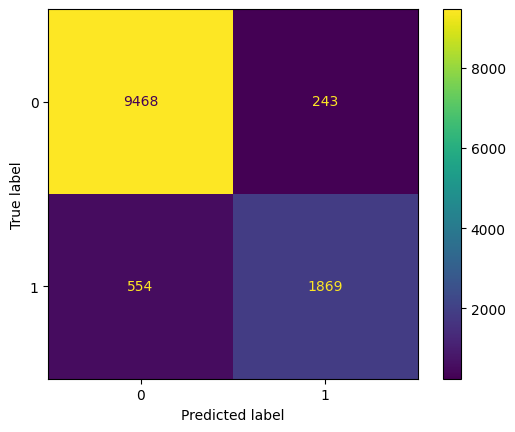

In [35]:
y_pred = search.predict(X_test)
y_pred_proba = search.predict_proba(X_test)
utilities.metrics_display(y_test, y_pred, y_pred_proba[:, 1])

#### 3. Refining search space

##### 1st run

In [36]:
top_n, best_score = utilities.extract_logs(search)
last_run_best_score.append(best_score)
if len(all_time_best_score)==0:
    all_time_best_score.append(best_score)
else:
    if all_time_best_score[0]<best_score:
        all_time_best_score[0] = best_score
prompt = utilities.suggest_refine_search_space(top_n, last_run_best_score[-1], all_time_best_score[-1])

In [37]:
print(prompt)


    Given your previously suggested search space, the obtained top configurations with their 
    test scores:
    Configuration 1 (1.0000 test score): colsample_bylevel: 0.7858097999981662, colsample_bytree: 0.9654873771626764, gamma: 0.08900480121876064, learning_rate: 0.07560254083346492, max_depth: 6, min_child_weight: 0.5877941609592175, n_estimators: 730, reg_alpha: 0.605791319022532, reg_lambda: 0.6169449209643788, scale_pos_weight: 1.8014085950051941, subsample: 0.6753683581577532
Configuration 2 (1.0000 test score): colsample_bylevel: 0.680321736259335, colsample_bytree: 0.8988049873053678, gamma: 0.23163458699528333, learning_rate: 0.052542398975341624, max_depth: 4, min_child_weight: 0.8794279161835195, n_estimators: 565, reg_alpha: 0.5780015306201536, reg_lambda: 0.9127783956352171, scale_pos_weight: 8.96020799447713, subsample: 0.6409565323737958
Configuration 3 (1.0000 test score): colsample_bylevel: 0.9149611264346803, colsample_bytree: 0.8103745466327344, gamma: 0.4575

In [38]:
response = conversation.predict(input=prompt)
print(response)

In XGBoost tuning, it is common practice to iteratively refine the search space based on insights gained from previous optimization rounds to further improve model performance. When refining the search space, it is essential to strike a balance between exploring a diverse set of hyperparameters and focusing on promising regions that have shown success in previous runs.

Based on the provided search history with all configurations achieving a perfect score of 1.0, it indicates that the model is potentially overfitting the training data. To address potential overfitting and further explore the search space, the following refinements are suggested:

1. **Narrowing the Range**:
   - **max_depth**: Restricting the maximum tree depth can help prevent overfitting by limiting the complexity of individual trees.
   - **learning_rate**: Narrowing down the range of learning rates can focus the search on more optimal step sizes for boosting.

2. **Expanding the Range**:
   - **gamma**: Broadening 

In [39]:
%%time

search_space = {
    "n_estimators": randint(100, 1000),
    "max_depth": randint(3, 6),  # Narrowed down the range
    "min_child_weight": uniform(0.1, 1.0),
    "gamma": uniform(0, 0.5),
    "scale_pos_weight": uniform(1, 20),  # Expanded the range
    "learning_rate": uniform(0.01, 0.2),  # Narrowed down the range
    "subsample": uniform(0.6, 0.4),
    "colsample_bylevel": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "reg_alpha": uniform(0, 1),
    "reg_lambda": uniform(0, 1)
}


clf = xgb.XGBClassifier(seed=42, objective='binary:logistic', 
                        eval_metric='logloss', n_jobs=-1, use_label_encoder=False)

search = HalvingRandomSearchCV(clf, search_space, scoring='f1', n_candidates=500,
                              cv=5, min_resources='exhaust', factor=3, verbose=1).fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 325
max_resources_: 78999
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 500
n_resources: 325
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
----------
iter: 1
n_candidates: 167
n_resources: 975
Fitting 5 folds for each of 167 candidates, totalling 835 fits
----------
iter: 2
n_candidates: 56
n_resources: 2925
Fitting 5 folds for each of 56 candidates, totalling 280 fits
----------
iter: 3
n_candidates: 19
n_resources: 8775
Fitting 5 folds for each of 19 candidates, totalling 95 fits
----------
iter: 4
n_candidates: 7
n_resources: 26325
Fitting 5 folds for each of 7 candidates, totalling 35 fits
CPU times: total: 1h 2min 48s
Wall time: 6min 54s


##### Assessing performance

ROC_AUC score: 0.981
f1 score: 0.832
Accuracy: 93.66%
Precision: 88.43%
Detection rate: 78.54%
False alarm rate: 2.564102564102564%
MCC: 0.80


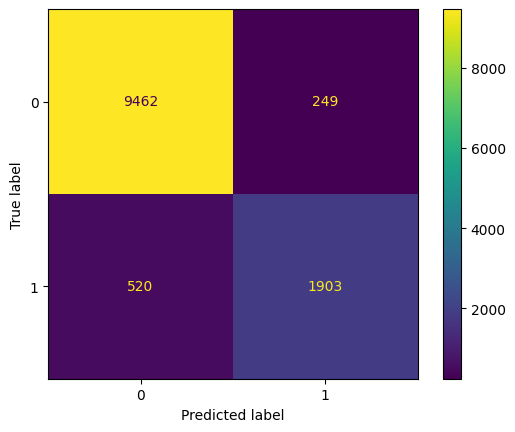

In [40]:
y_pred = search.predict(X_test)
y_pred_proba = search.predict_proba(X_test)
utilities.metrics_display(y_test, y_pred, y_pred_proba[:, 1])

##### 2nd run

In [41]:
top_n, best_score = utilities.extract_logs(search)
last_run_best_score.append(best_score)
if len(all_time_best_score)==0:
    all_time_best_score.append(best_score)
else:
    if all_time_best_score[0]<best_score:
        all_time_best_score[0] = best_score
prompt = utilities.suggest_refine_search_space(top_n, last_run_best_score[-1], all_time_best_score[-1])
print(prompt)


    Given your previously suggested search space, the obtained top configurations with their 
    test scores:
    Configuration 1 (0.9971 test score): colsample_bylevel: 0.787167155410774, colsample_bytree: 0.659251953811532, gamma: 0.282964283849463, learning_rate: 0.05452770845291363, max_depth: 5, min_child_weight: 1.0994692910463375, n_estimators: 701, reg_alpha: 0.8662054597787268, reg_lambda: 0.47081900755632033, scale_pos_weight: 9.408364552446887, subsample: 0.6616510578231941
Configuration 2 (0.9971 test score): colsample_bylevel: 0.6890961032205428, colsample_bytree: 0.7835680906331516, gamma: 0.08188462279532838, learning_rate: 0.16659542230997096, max_depth: 4, min_child_weight: 0.9640283031317674, n_estimators: 941, reg_alpha: 0.24411237193899238, reg_lambda: 0.6835269792037764, scale_pos_weight: 20.823184056169424, subsample: 0.7492018807802074
Configuration 3 (0.9970 test score): colsample_bylevel: 0.6511945883636207, colsample_bytree: 0.8351453846894324, gamma: 0.4682

In [42]:
response = conversation.predict(input=prompt)
print(response)

In XGBoost tuning, the goal is to find a balance between model complexity and generalization to achieve the best performance on unseen data. The provided search history shows that the model performance has slightly decreased from perfect scores to high but not perfect scores, indicating a potential decrease in overfitting. To further refine the search space for hyperparameters, we can focus on areas that have shown promising results while also exploring new regions for potential improvements.

Based on the insights from the search history and the need to continue exploring the search space effectively, the following refinements are recommended:

1. **Narrowing the Range**:
   - **max_depth**: Further constrain the range of maximum tree depth to encourage simpler models and reduce the risk of overfitting.
   - **learning_rate**: Narrowing down the learning rate range to focus on smaller step sizes for more precise updates.

2. **Expanding the Range**:
   - **gamma**: Broadening the gamm

In [43]:
%%time

search_space = {
    "n_estimators": randint(500, 1000),  # Narrowed down the range
    "max_depth": randint(3, 5),  # Narrowed down the range
    "min_child_weight": uniform(0.1, 1.0),
    "gamma": uniform(0, 0.5),  # Expanded the range
    "scale_pos_weight": uniform(1, 30),  # Expanded the range
    "learning_rate": uniform(0.01, 0.2),  # Narrowed down the range
    "subsample": uniform(0.6, 0.4),
    "colsample_bylevel": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "reg_alpha": uniform(0, 1),
    "reg_lambda": uniform(0, 1)
}


clf = xgb.XGBClassifier(seed=42, objective='binary:logistic', 
                        eval_metric='logloss', n_jobs=-1, use_label_encoder=False)

search = HalvingRandomSearchCV(clf, search_space, scoring='f1', n_candidates=500,
                              cv=5, min_resources='exhaust', factor=3, verbose=1).fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 325
max_resources_: 78999
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 500
n_resources: 325
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
----------
iter: 1
n_candidates: 167
n_resources: 975
Fitting 5 folds for each of 167 candidates, totalling 835 fits
----------
iter: 2
n_candidates: 56
n_resources: 2925
Fitting 5 folds for each of 56 candidates, totalling 280 fits
----------
iter: 3
n_candidates: 19
n_resources: 8775
Fitting 5 folds for each of 19 candidates, totalling 95 fits
----------
iter: 4
n_candidates: 7
n_resources: 26325
Fitting 5 folds for each of 7 candidates, totalling 35 fits
CPU times: total: 1h 12min 32s
Wall time: 8min 4s


##### Assessing performance

ROC_AUC score: 0.970
f1 score: 0.813
Accuracy: 93.06%
Precision: 87.95%
Detection rate: 75.61%
False alarm rate: 2.584697765420657%
MCC: 0.77


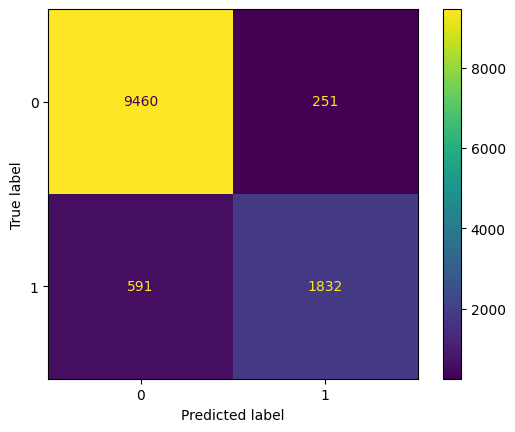

In [44]:
y_pred = search.predict(X_test)
y_pred_proba = search.predict_proba(X_test)
utilities.metrics_display(y_test, y_pred, y_pred_proba[:, 1])

#### 3rd run

In [45]:
top_n, best_score = utilities.extract_logs(search)
last_run_best_score.append(best_score)
if len(all_time_best_score)==0:
    all_time_best_score.append(best_score)
else:
    if all_time_best_score[0]<best_score:
        all_time_best_score[0] = best_score
prompt = utilities.suggest_refine_search_space(top_n, last_run_best_score[-1], all_time_best_score[-1])
print(prompt)


    Given your previously suggested search space, the obtained top configurations with their 
    test scores:
    Configuration 1 (0.9964 test score): colsample_bylevel: 0.9742558159118831, colsample_bytree: 0.6351274506781681, gamma: 0.035452899410997274, learning_rate: 0.06488196218127233, max_depth: 3, min_child_weight: 0.4267138820033478, n_estimators: 637, reg_alpha: 0.017392485483761932, reg_lambda: 0.7597971549822374, scale_pos_weight: 25.0501091849619, subsample: 0.8473362955111834
Configuration 2 (0.9963 test score): colsample_bylevel: 0.6053659015050832, colsample_bytree: 0.7322462436552999, gamma: 0.2553042596361329, learning_rate: 0.13598717488016235, max_depth: 4, min_child_weight: 0.18655031395970548, n_estimators: 710, reg_alpha: 0.26755529401479883, reg_lambda: 0.061712488566279644, scale_pos_weight: 5.96206103469658, subsample: 0.6500628024672715
Configuration 3 (0.9963 test score): colsample_bylevel: 0.6420275810325521, colsample_bytree: 0.6693024820402598, gamma: 0

In [46]:
response = conversation.predict(input=prompt)
print(response)

Given the search history where the model's performance has remained consistently high but not perfect, it indicates a good level of generalization and potential avoidance of overfitting. To further refine the search space for hyperparameters and potentially improve the model's performance, the following adjustments are recommended:

1. **Narrowing the Range**:
   - **max_depth**: Continuing to constrain the maximum tree depth can encourage simpler models and better generalization.
   - **learning_rate**: Narrowing down the learning rate range further can help focus on more precise updates during boosting.

2. **Expanding the Range**:
   - **gamma**: Broadening the gamma range to explore a wider range of loss reduction thresholds can help in finding optimal splitting strategies.
   - **scale_pos_weight**: Extending the scale_pos_weight range even further to allow for more diverse exploration of class weight balancing.

These refinements aim to continue the balance between exploration an

In [47]:
%%time

search_space = {
    "n_estimators": randint(500, 1000),
    "max_depth": randint(3, 5),  # Narrowed down the range
    "min_child_weight": uniform(0.1, 1.0),
    "gamma": uniform(0, 0.5),  # Expanded the range
    "scale_pos_weight": uniform(1, 40),  # Expanded the range
    "learning_rate": uniform(0.01, 0.2),  # Narrowed down the range
    "subsample": uniform(0.6, 0.4),
    "colsample_bylevel": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "reg_alpha": uniform(0, 1),
    "reg_lambda": uniform(0, 1)
}



clf = xgb.XGBClassifier(seed=42, objective='binary:logistic', 
                        eval_metric='logloss', n_jobs=-1, use_label_encoder=False)

search = HalvingRandomSearchCV(clf, search_space, scoring='f1', n_candidates=500,
                              cv=5, min_resources='exhaust', factor=3, verbose=1).fit(X_train, y_train)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 325
max_resources_: 78999
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 500
n_resources: 325
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
----------
iter: 1
n_candidates: 167
n_resources: 975
Fitting 5 folds for each of 167 candidates, totalling 835 fits
----------
iter: 2
n_candidates: 56
n_resources: 2925
Fitting 5 folds for each of 56 candidates, totalling 280 fits
----------
iter: 3
n_candidates: 19
n_resources: 8775
Fitting 5 folds for each of 19 candidates, totalling 95 fits
----------
iter: 4
n_candidates: 7
n_resources: 26325
Fitting 5 folds for each of 7 candidates, totalling 35 fits
CPU times: total: 1h 12min 3s
Wall time: 7min 53s


##### Assessing performance

ROC_AUC score: 0.970
f1 score: 0.784
Accuracy: 92.21%
Precision: 87.78%
Detection rate: 70.86%
False alarm rate: 2.4611265575120997%
MCC: 0.74


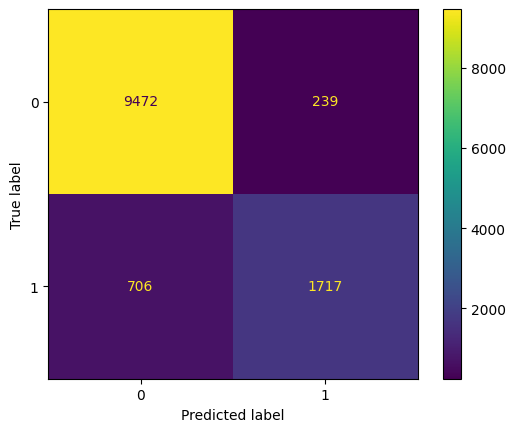

In [48]:
y_pred = search.predict(X_test)
y_pred_proba = search.predict_proba(X_test)
utilities.metrics_display(y_test, y_pred, y_pred_proba[:, 1])

In [49]:
top_n, best_score = utilities.extract_logs(search)
last_run_best_score.append(best_score)
if len(all_time_best_score)==0:
    all_time_best_score.append(best_score)
else:
    if all_time_best_score[0]<best_score:
        all_time_best_score[0] = best_score
prompt = utilities.suggest_refine_search_space(top_n, last_run_best_score[-1], all_time_best_score[-1])
print(prompt)


    Given your previously suggested search space, the obtained top configurations with their 
    test scores:
    Configuration 1 (0.9961 test score): colsample_bylevel: 0.7424644174331432, colsample_bytree: 0.725833510322021, gamma: 0.11862676942237288, learning_rate: 0.12176520086355795, max_depth: 3, min_child_weight: 0.5071462585261656, n_estimators: 593, reg_alpha: 0.08608964949227937, reg_lambda: 0.5684448510951444, scale_pos_weight: 12.266668362562783, subsample: 0.9882552444309418
Configuration 2 (0.9959 test score): colsample_bylevel: 0.6209045840365572, colsample_bytree: 0.8381400755574993, gamma: 0.029956489411283482, learning_rate: 0.043922672302724744, max_depth: 4, min_child_weight: 0.13034174573579907, n_estimators: 732, reg_alpha: 0.48121982268512264, reg_lambda: 0.38585248296497754, scale_pos_weight: 2.0591156248660383, subsample: 0.8158604607824276
Configuration 3 (0.9959 test score): colsample_bylevel: 0.8742757475762257, colsample_bytree: 0.622011057715745, gamma: